Import libraries and data, and make the plot presentable.

In [201]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action="ignore")

import matplotlib.pyplot as plt
from copy import deepcopy

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [202]:
sales = pd.read_csv("TOTALSA.csv", parse_dates=["DATE"]).rename(columns = {'TOTALSA': "Sales"})

GDP = pd.read_csv("GDP.csv", parse_dates=["DATE"]).assign(GDP = lambda cols: cols['GDP']/1000)

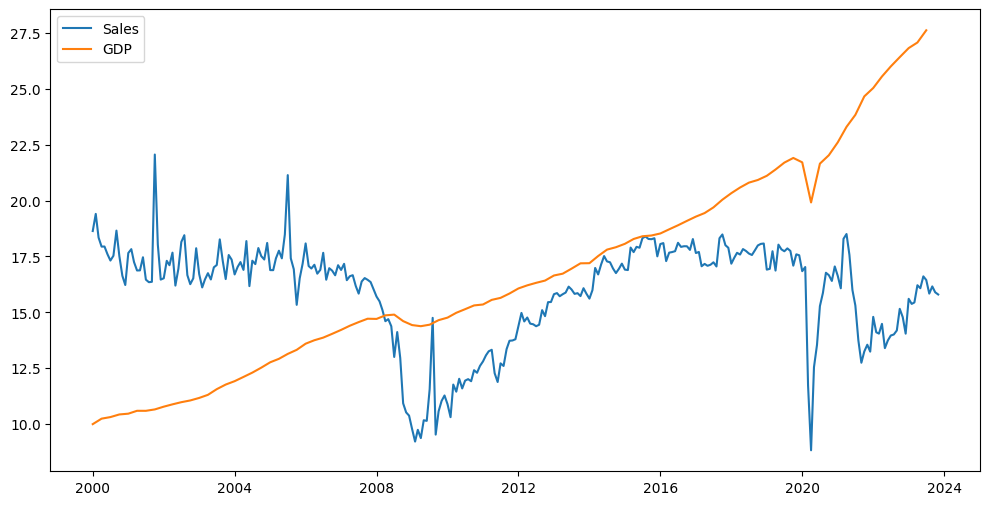

In [203]:
plt.figure(figsize= [12,6])
plt.plot(sales["DATE"], sales['Sales'], label="Sales")
plt.plot(GDP["DATE"], GDP["GDP"], label="GDP")
plt.legend()
plt.show()

In [204]:
GDP

,DATE,GDP
0,2000-01-01,10.002179
1,2000-04-01,10.247720
2,2000-07-01,10.318165
3,2000-10-01,10.435744
4,2001-01-01,10.470231
...,...,...
90,2022-07-01,25.994639
91,2022-10-01,26.408405
92,2023-01-01,26.813601
93,2023-04-01,27.063012


Right now , GDP table is indexed quarterly and not monthly like our dataset sales. Let's fix that! 
First, we displace our time grains by one month (to later help computing the missing month entries)

In [205]:
GDP = GDP.assign(DATE = lambda cols: cols["DATE"] + pd.Timedelta(31, 'D'))\
    .assign(DATE = lambda cols: cols["DATE"].apply(lambda x: x.replace(day=1)))

GDP

,DATE,GDP
0,2000-02-01,10.002179
1,2000-05-01,10.247720
2,2000-08-01,10.318165
3,2000-11-01,10.435744
4,2001-02-01,10.470231
...,...,...
90,2022-08-01,25.994639
91,2022-11-01,26.408405
92,2023-02-01,26.813601
93,2023-05-01,27.063012


In [206]:
df = pd.merge(
    left = sales,
    right = GDP,
    on = "DATE",
    how = "outer"
)

df 

,DATE,Sales,GDP
0,2000-01-01,18.635,NaN
1,2000-02-01,19.401,10.002179
2,2000-03-01,18.343,NaN
3,2000-04-01,17.939,NaN
4,2000-05-01,17.943,10.247720
...,...,...,...
282,2023-07-01,16.446,NaN
283,2023-08-01,15.838,27.610128
284,2023-09-01,16.160,NaN
285,2023-10-01,15.897,NaN


Now, the table has GDP and sales with shared date indexes. (Still missing entries though)

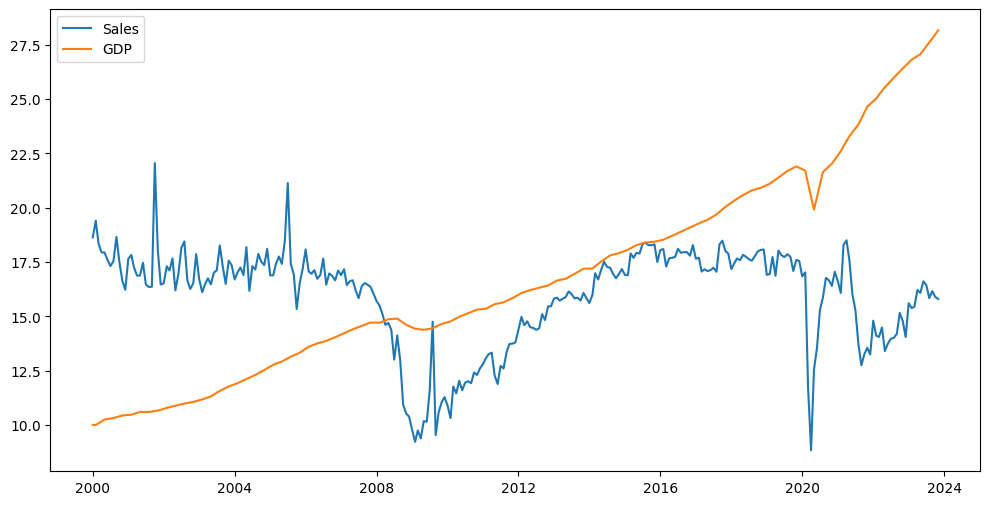

In [207]:
df["GDP"] = df["GDP"].interpolate(method ='linear', limit_direction='backward')
GDP_avg_growth = (df["GDP"] / df["GDP"].shift(1)).dropna().tail(3).mean()

for i in range(df.shape[0]):
    if (pd.isnull(df.loc[i, 'GDP'])):
        df.loc[i, 'GDP'] = df.loc[i-1, "GDP"] * GDP_avg_growth

        
df.tail(15)

plt.figure(figsize= [12,6])
plt.plot(df["DATE"], df['Sales'], label="Sales")
plt.plot(df["DATE"], df["GDP"], label="GDP")
plt.legend()
plt.show()

Now we can create our training and test sets! (we will cut off the last 20 sets or around 2022 for our train set)

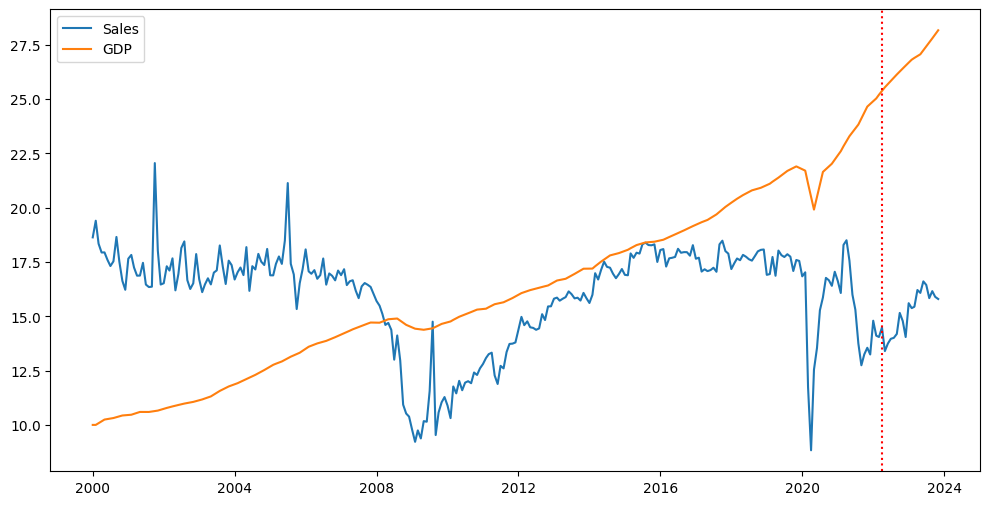

In [208]:
MAX_TRAINING_DATE = df.tail(20).iloc[0]["DATE"]

plt.figure(figsize= [12,6])
plt.plot(df["DATE"], df['Sales'], label="Sales")
plt.plot(df["DATE"], df["GDP"], label="GDP")
plt.axvline(MAX_TRAINING_DATE, color = 'red', linestyle = 'dotted')
plt.legend()
plt.show()

df_train = df.loc[df["DATE"] < MAX_TRAINING_DATE, :]
df_test = df.loc[df["DATE"] >= MAX_TRAINING_DATE, :]

Let's build our SARIMAX model (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors).

We don't know what the parameters are going to be for now, so we guess these values.

Optimization terminated successfully.
         Current function value: 1.359424
         Iterations: 39
         Function evaluations: 72
         Gradient evaluations: 72


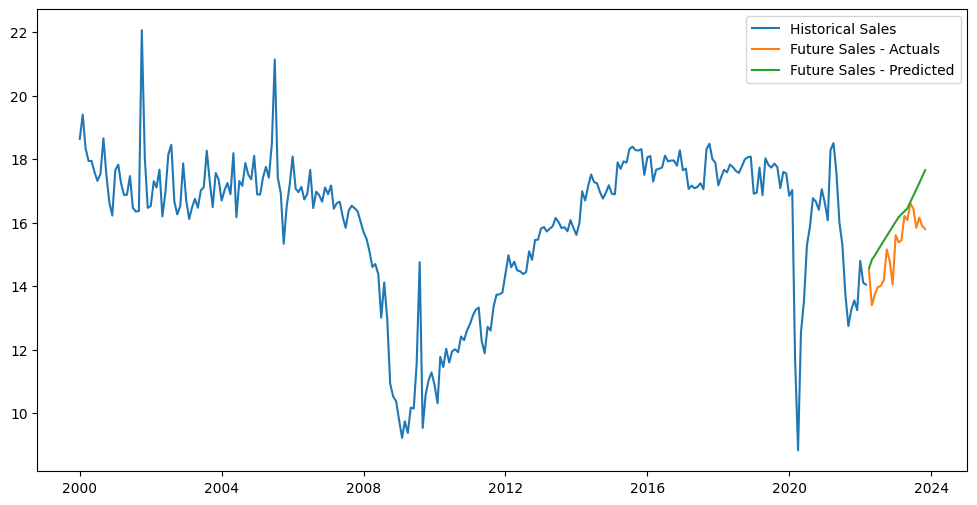

In [209]:
model = SARIMAX(
    endog = df_train["Sales"],
    exog = df_train["GDP"],
    order = (1,1,3), # arima orders : p,d,q
    trend = [0,0], # A(t) = a0 + a1*t + a2*t^2 + ...
    seasonal_order = (1,0,0,12) # P, D, Q seasonal order parameters
).fit(method='cg')

forecast = model.forecast(steps=df_test.shape[0], exog = df_test["GDP"])

plt.figure(figsize=(12,6))
plt.plot(df_train["DATE"], df_train["Sales"], label="Historical Sales")
plt.plot(df_test["DATE"], df_test["Sales"], label="Future Sales - Actuals")
plt.plot(df_test["DATE"], forecast, label="Future Sales - Predicted")

plt.legend()
plt.show()

Now, the shape is ... alright... but we can make it way better by correctly tweaking the parameters of our SARIMAX model.
So, we are going to construct a scoring system function with a search function to find the optimized hyperparametric combination.